#Tutorial 5 - DQN

Please follow this tutorial to understand the structure (code) of DQN algorithm.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding of the core concepts. Contact the TAs for further resources if needed.


In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Le chemin d'accŠs sp‚cifi‚ est introuvable.
Le chemin d'accŠs sp‚cifi‚ est introuvable.
Le chemin d'accŠs sp‚cifi‚ est introuvable.
Le chemin d'accŠs sp‚cifi‚ est introuvable.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Le chemin d'accŠs sp‚cifi‚ est introuvable.
Le chemin d'accŠs sp‚cifi‚ est introuvable.
Le chemin d'accŠs sp‚cifi‚ est introuvable.


  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [94 lines of output]
  
  
  WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
  Using WINDOWS configuration...
  
  Making dir :prebuilt_downloads:
  Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
  
  ---
  For help with compilation see:
      https://www.pygame.org/wiki/CompileWindows
  To contribute to pygame development see:
      https://www.pygame.org/contribute.html
  ---
  
  Traceback (most recent call last):
    File "C:\Users\jules\AppData\Local\Programs\Python\Python312\Lib\urllib\request.py", line 1344, in do_open
      h.request(req.get_method(), req.selector, req.data, headers,
    File "C:\Users\jules\AppData\Local\Programs\Python\Python312\Lib\http\client.py", line 1319, in request
      self._send_request(method, url, body, headers, encode_chunked)
    File "C:\User

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

ModuleNotFoundError: No module named 'pyvirtualdisplay'

In [6]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
#env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info, _ = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
1
----
(array([-0.00756943,  0.01628525, -0.03592916, -0.00511707], dtype=float32), {})
----
0
----
[-0.00724373 -0.1783035  -0.0360315   0.27601677]
1.0
False
False
----


C:\Users\jules\Documents\IITM\RL - CS6700\assignement 2\RL-assignement-2\.venv\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [22]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.advfc3 = nn.Linear(fc2_units, fc2_units)
        self.advfc4 = nn.Linear(fc2_units, action_size)
        self.valfc3 = nn.Linear(fc2_units, fc2_units)
        self.valfc4 = nn.Linear(fc2_units, 1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        adv = F.relu(self.advfc3(x))
        adv = self.advfc4(adv)

        val = F.relu(self.valfc3(x))
        val = self.valfc4(val)
        
        return val + adv - adv.mean(1).unsqueeze(1)

### Replay Buffer:

Recall why we use such a technique.

In [23]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [24]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

In [25]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


def dqn(n_episodes=10000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, tau=0):

    scores_window = deque(maxlen=100)
    ''' last 100 scores for checking if the avg is more than 195 '''

    scores_over_episodes=[]

    eps = eps_start
    ''' initialize epsilon '''

    for i_episode in range(1, n_episodes+1):
        state = env.reset()[0]
        score = 0
        for t in range(max_t):
            if tau!=0:
              action = agent.act(state, tau)
            else:
              action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)
        scores_over_episodes.append(score)

        eps = max(eps_end, eps_decay*eps)
        ''' decrease epsilon '''

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
           break
    return scores_over_episodes


### Task 1 solution

In [26]:
class SoftmaxAgent(TutorialAgent):

  def __init__(self, state_size, action_size, seed):
    super().__init__(state_size, action_size, seed)

  def act(self, state, tau=0.):
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
        action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    ''' Softmax action selection '''
    action_values_table = action_values.cpu().data.numpy()[0]
    probabilities = np.exp((action_values_table - np.max(action_values_table)) / tau) / np.sum(np.exp((action_values_table  - np.max(action_values_table))/ tau))
    return int(np.random.choice(len(action_values_table), p=probabilities))

### Task 2 solution

---Epsilon-greedy agent---
Episode 100	Average Score: 36.65
Episode 200	Average Score: 69.10
Episode 300	Average Score: 117.14
Episode 400	Average Score: 93.504
Episode 500	Average Score: 164.54
Episode 600	Average Score: 71.220
Episode 700	Average Score: 147.64
Episode 730	Average Score: 195.93
Environment solved in 730 episodes!	Average Score: 195.93
Epsilon-greedy took  0:08:24.506655
---Softmax agent---
Episode 100	Average Score: 146.73
Episode 117	Average Score: 203.97
Environment solved in 117 episodes!	Average Score: 203.97
Softmax took  0:02:21.596929


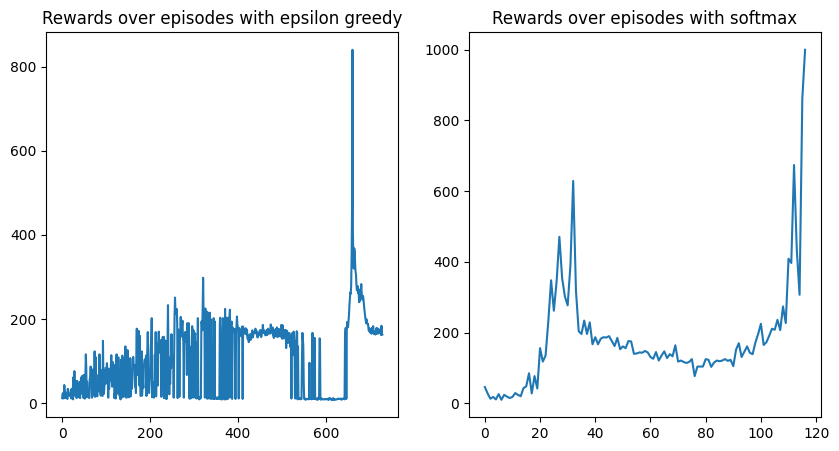

In [27]:
print("---Epsilon-greedy agent---")
begin_time = datetime.datetime.now()

agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)
scores=dqn()

time_taken = datetime.datetime.now() - begin_time

print("Epsilon-greedy took ",time_taken)
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.arange(len(scores)),scores)
ax[0].set_title("Rewards over episodes with epsilon greedy")

print("---Softmax agent---")
begin_time = datetime.datetime.now()

agent = SoftmaxAgent(state_size=state_shape,action_size = action_shape,seed = 0)
scores = dqn(tau=1)

time_taken = datetime.datetime.now() - begin_time
print("Softmax took ",time_taken)

ax[1].plot(np.arange(len(scores)),scores)
ax[1].set_title("Rewards over episodes with softmax")
plt.show()


- the $\epsilon$-greedy agent solves the problem in 221 episodes while softmax agent solves it in 104 episodes.
- We can observe that the reward seems more stable with softmax than with $\epsilon$-greedy. At a certain point, softmax doesn't go very low whereas $\epsilon$-greedy keeps having low rewards sometimes.
- Computationaly, $\epsilon$-greedy has an average of 446 ms per episode and softmax has an average of 624 ms per episode so softmax is heavier computationnaly even if it is still faster because it learnt in less episodes.